In [1]:
import os
os.chdir('/Users/schoens/Documents/PhD/IIASA/04_Code/income_decile')

In [2]:
from pathlib import Path

import pandas as pd 
import numpy as np
import xarray as xr
import geopandas as gpd 
from shapely import box
import pycountry

from tqdm.notebook import tqdm

import config.config as cfg 
from config.config import (PROCESSED_GMT_FILE,
                           GRAPHICS_DIR, GRAPHICS_PAPER_MAIN_DIR, GRAPHICS_PAPER_APPENDIX_DIR, 
                           RESULTS_DIR,
                           fontsize_medium,
                           fontsize_small,
                           fontsize_large, 
                           regions,
                           region_naming_dict, 
                           population_shares, 
                           group_colors,
                           uncertainty_color,
                           sensitvitiy_color,
                           symbols,
                           EU27_ids
                           )
from utils.plotting_functions import lighten_color

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colormaps as cmaps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_rgba
import matplotlib.colors as cm
from matplotlib.legend_handler import HandlerTuple

from tabulate import tabulate

from itertools import product
import regionmask

plt.rcParams['svg.fonttype'] = 'none'

In [3]:
tas_frequency_df = xr.open_dataset(RESULTS_DIR / 'tas_frequency_hot.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')
spei_frequency_df = xr.open_dataset(RESULTS_DIR / 'spei_frequency_dry.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')
tas_intensity_df = xr.open_dataset(RESULTS_DIR / 'tas_intensity_hot.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')
spei_intensity_df = xr.open_dataset(RESULTS_DIR / 'spei_intensity_dry.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')

In [5]:
region = 'IN'
group  = 'p90p100'
lower_bounds_tas = tas_frequency_df['attributed_tas'].sel(region = region, group = group, month = 7,).isel(extreme_quantile = 1).quantile(q = 0.05, dim = 'model').values
lower_bounds_spei = spei_frequency_df['attributed_spei'].sel(region = region, group = group, month = 7,).isel(extreme_quantile = 1).quantile(q = 0.05, dim = 'model').values
medians_tas = tas_frequency_df['attributed_tas'].sel(region = region, group = group, month = 7,).isel(extreme_quantile = 1).mean(dim = 'model').values 
medians_spei = spei_frequency_df['attributed_spei'].sel(region = region, group = group, month = 7,).isel(extreme_quantile = 1).mean(dim = 'model').values 

len(medians_tas[(lower_bounds_tas > 0) & (lower_bounds_spei > 0)])

489

58.18250377073907 36.53846153846153 2.564102564102564 2.7149321266968327
40.79939668174962 44.68325791855204 3.8838612368024132 10.633484162895927
18.438914027149323 28.88386123680241 5.844645550527903 46.83257918552036
61.72699849170438 33.97435897435898 1.998491704374057 2.3001508295625945


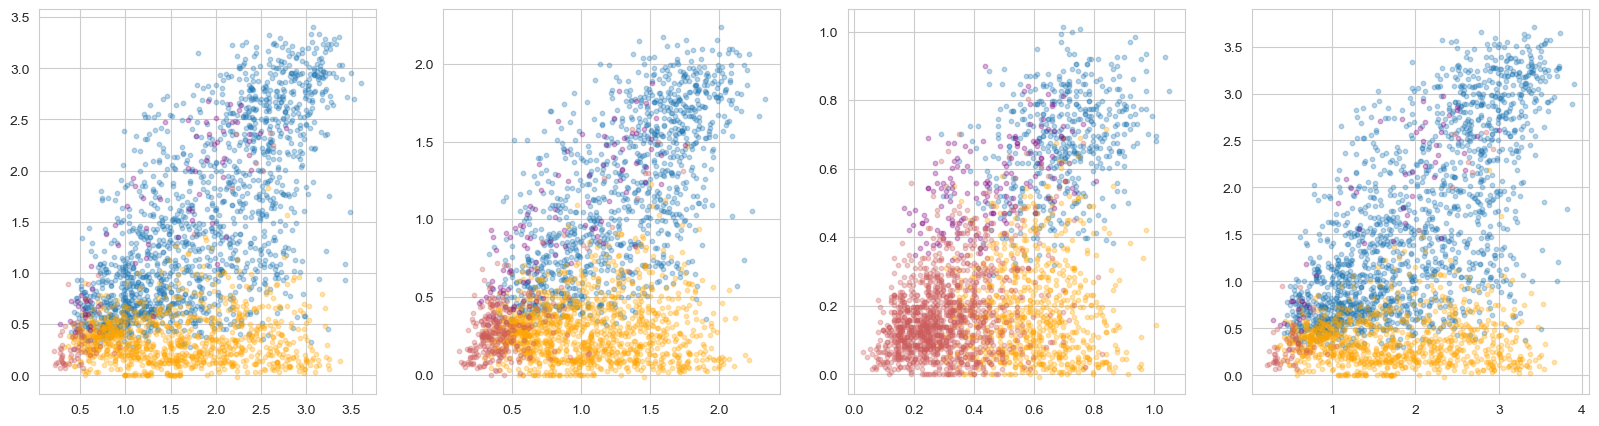

In [6]:
group = 'p90p100'
markers = ['o', 'o', 'o', 'o']

with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1,4, figsize = (20, 5))
    for i_region, region in enumerate(['US', 'EU27', 'IN', 'CN']): 
        ax = axes[i_region]
        lower_bounds_tas = tas_frequency_df['attributed_tas'].sel(region = region, group = group, month = 7,).isel(extreme_quantile = 1).quantile(q = 0.05, dim = 'model').values
        lower_bounds_spei = spei_frequency_df['attributed_spei'].sel(region = region, group = group, month = 7,).isel(extreme_quantile = 1).quantile(q = 0.05, dim = 'model').values
        medians_tas = tas_frequency_df['attributed_tas'].sel(region = region, group = group, month = 7,).isel(extreme_quantile = 1).mean(dim = 'model').values 
        medians_spei = spei_frequency_df['attributed_spei'].sel(region = region, group = group, month = 7,).isel(extreme_quantile = 1).mean(dim = 'model').values 
        
        ax.scatter(medians_tas[(lower_bounds_tas > 0) & (lower_bounds_spei > 0)],
                    medians_spei[(lower_bounds_tas > 0) & (lower_bounds_spei > 0)],
                    s = 10, 
                    alpha = .3,
                    color = 'C0',
                    marker = markers[i_region]
        )
        ax.scatter(medians_tas[(lower_bounds_tas > 0) & (lower_bounds_spei <= 0)],
                    medians_spei[(lower_bounds_tas > 0) & (lower_bounds_spei <= 0)],
                    s = 10,
                    alpha = 0.3,
                    marker = markers[i_region],
                    color = 'orange'
        )
        ax.scatter(medians_tas[(lower_bounds_tas <= 0) & (lower_bounds_spei > 0)],
                    medians_spei[(lower_bounds_tas <= 0) & (lower_bounds_spei > 0)],
                    s = 10,
                    alpha = 0.3,
                    marker = markers[i_region],
                    color = 'purple'
        )
        ax.scatter(medians_tas[(lower_bounds_tas <= 0) & (lower_bounds_spei <= 0)],
                    medians_spei[(lower_bounds_tas <= 0) & (lower_bounds_spei <= 0)],
                    s = 10,
                    alpha = 0.3,
                    marker = markers[i_region],
                    color = 'indianred'
        )
        print(len(medians_tas[(lower_bounds_tas > 0) & (lower_bounds_spei > 0)])/2652*100, 
              len(medians_tas[(lower_bounds_tas > 0) & (lower_bounds_spei <= 0)])/2652*100,
              len(medians_tas[(lower_bounds_tas <= 0) & (lower_bounds_spei > 0)])/2652*100,
              len(medians_tas[(lower_bounds_tas <= 0) & (lower_bounds_spei <= 0)])/2652*100
        )
    plt.show()

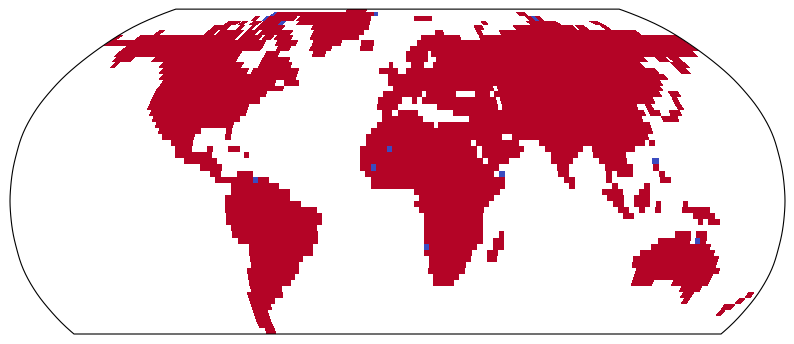

In [7]:
region = 'IN'
group = 'p99p100'
extreme_quantile = 1
month = 10
 
lower_bounds_tas = tas_frequency_df['attributed_tas'].sel(region = region, group = group, month = month).isel(extreme_quantile = extreme_quantile).quantile(q = 0.05, dim = 'model').values
lower_bounds_spei = spei_frequency_df['attributed_spei'].sel(region = region, group = group, month = month).isel(extreme_quantile = extreme_quantile).quantile(q = 0.05, dim = 'model').values
medians_tas = tas_frequency_df['attributed_tas'].sel(region = region, group = group, month = month).isel(extreme_quantile = extreme_quantile).mean(dim = 'model').values 
medians_spei = spei_frequency_df['attributed_spei'].sel(region = region, group = group, month = month).isel(extreme_quantile = extreme_quantile).mean(dim = 'model').values 

insig = tas_frequency_df['coords'].values[(lower_bounds_tas <= 0) & (lower_bounds_spei <= 0)]

binary = (lower_bounds_tas <= 0) & (lower_bounds_spei <= 0)*1

bool_df  = xr.DataArray(binary, coords = {'coords': tas_frequency_df['coords']}, dims = 'coords').unstack('coords').sortby('lon')

fig, ax  = plt.subplots(figsize = (10, 10), subplot_kw = {'projection': ccrs.Robinson()})
# ax.coatlines()
bool_df.plot(ax = ax, cmap = 'coolwarm', add_colorbar = False, transform = ccrs.PlateCarree())
plt.show()

In [8]:
import regionmask 

# selecting regions
ar6 = regionmask.defined_regions.ar6.land
mask = ar6.mask(tas_frequency_df)
df_agg_tas = tas_frequency_df.groupby(mask).median('coords')
df_agg_spei = spei_frequency_df.groupby(mask).median('coords')


In [9]:
magicc_df = pd.read_csv(RESULTS_DIR / 'Attributed_GMT.csv', index_col = 0)

magicc_region_dict = dict(zip(['global', 'US', 'EU27', 'IN', 'CN'], 
                              ['World', 'US', 'EU27', 'IN', 'CN']))
magicc_group_dict = dict(zip(['historic', 'all', 'top 10', 'top 1', 'top 0.1'], 
                              ['hisotric', 'p0p100', 'p90p100', 'p99p100', 'p999p1000']))

magicc_df['region'] = magicc_df['region'].map(magicc_region_dict)
magicc_df['group'] = magicc_df['group'].map(magicc_group_dict)

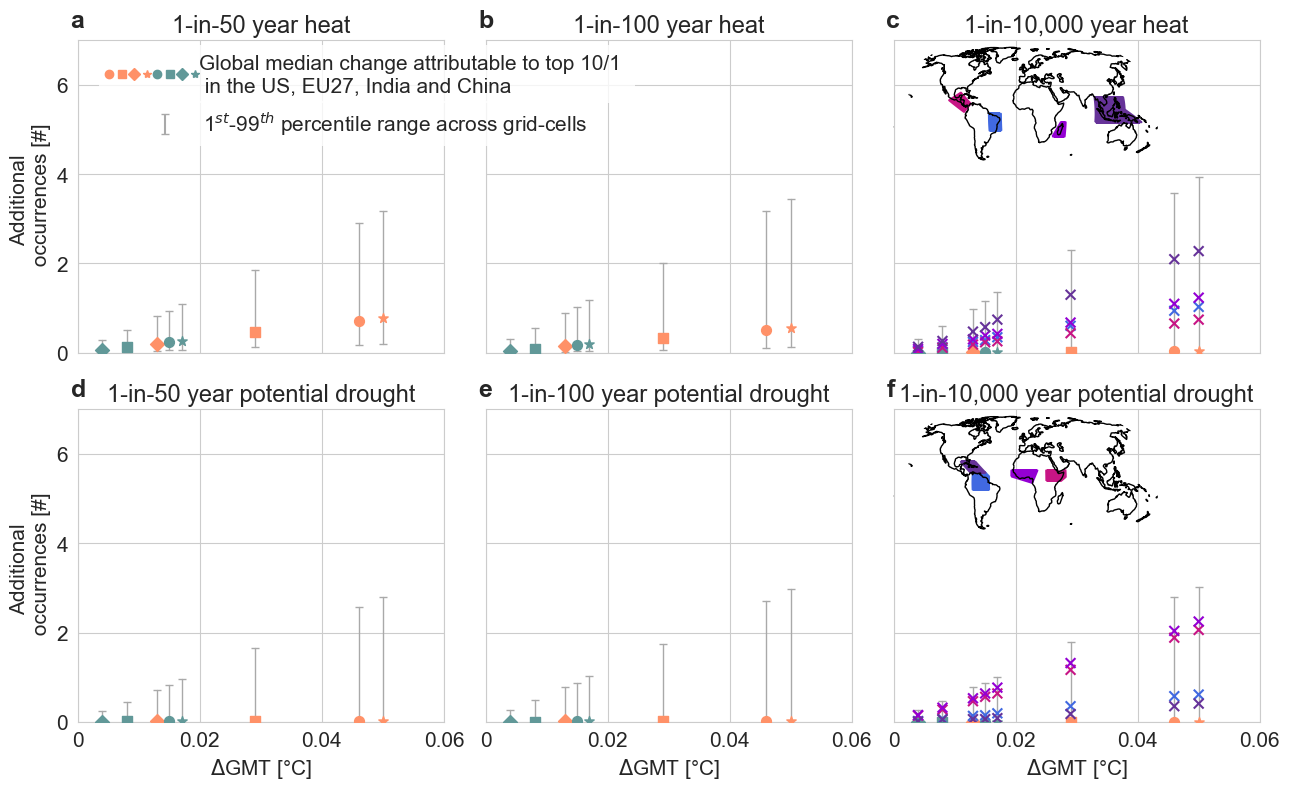

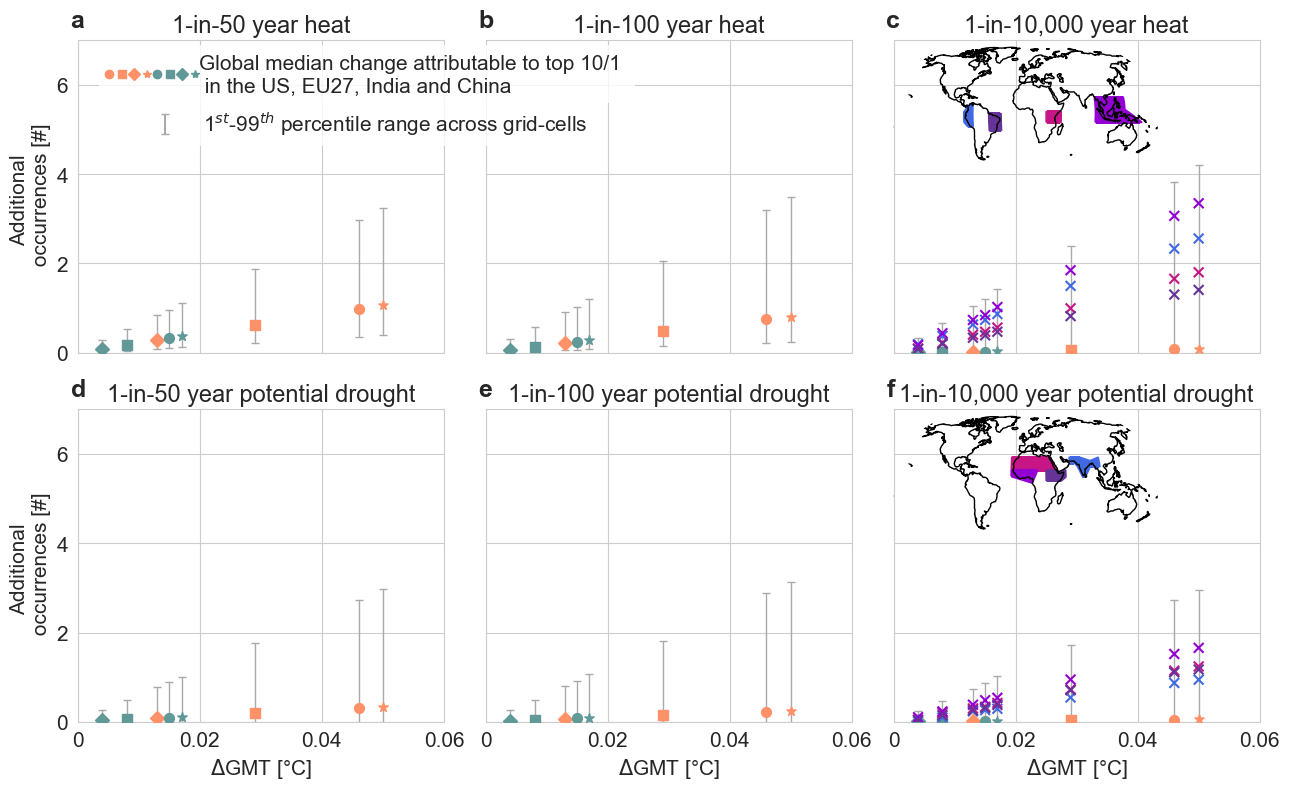

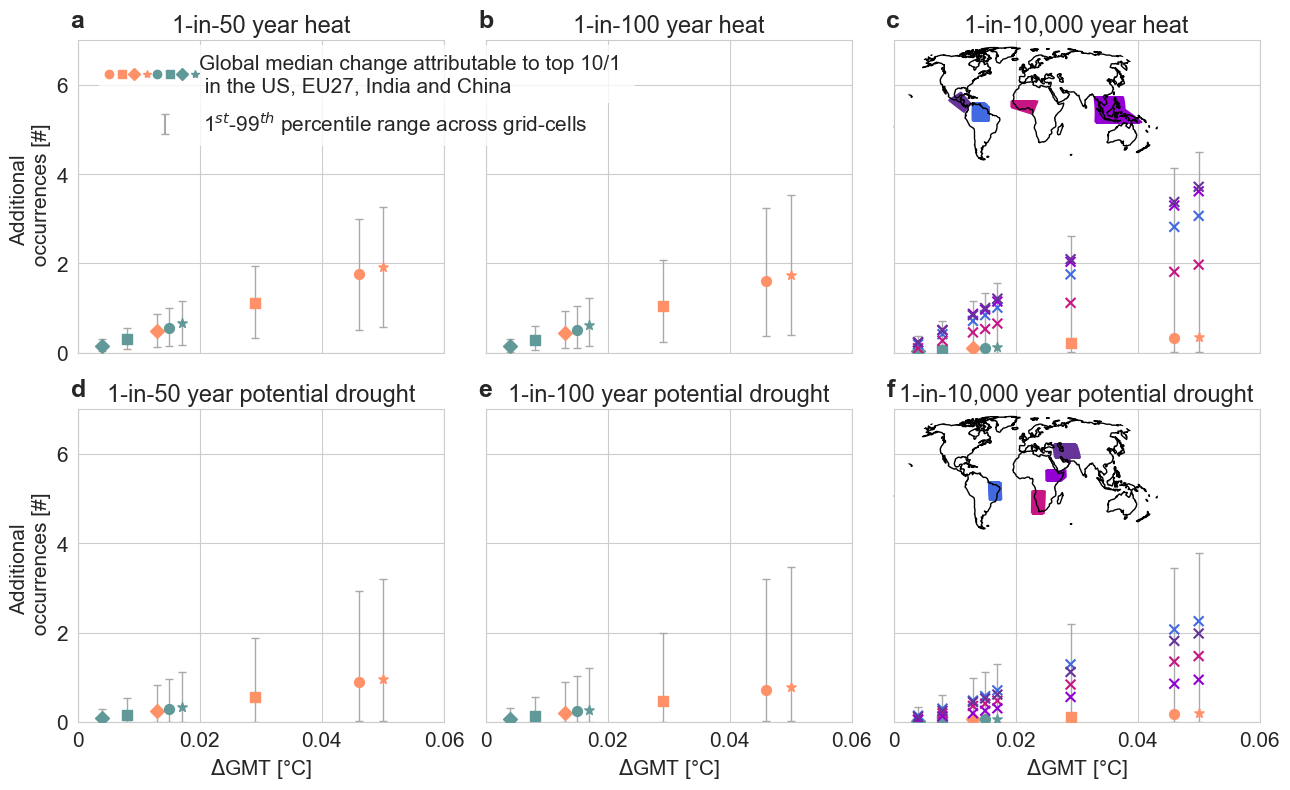

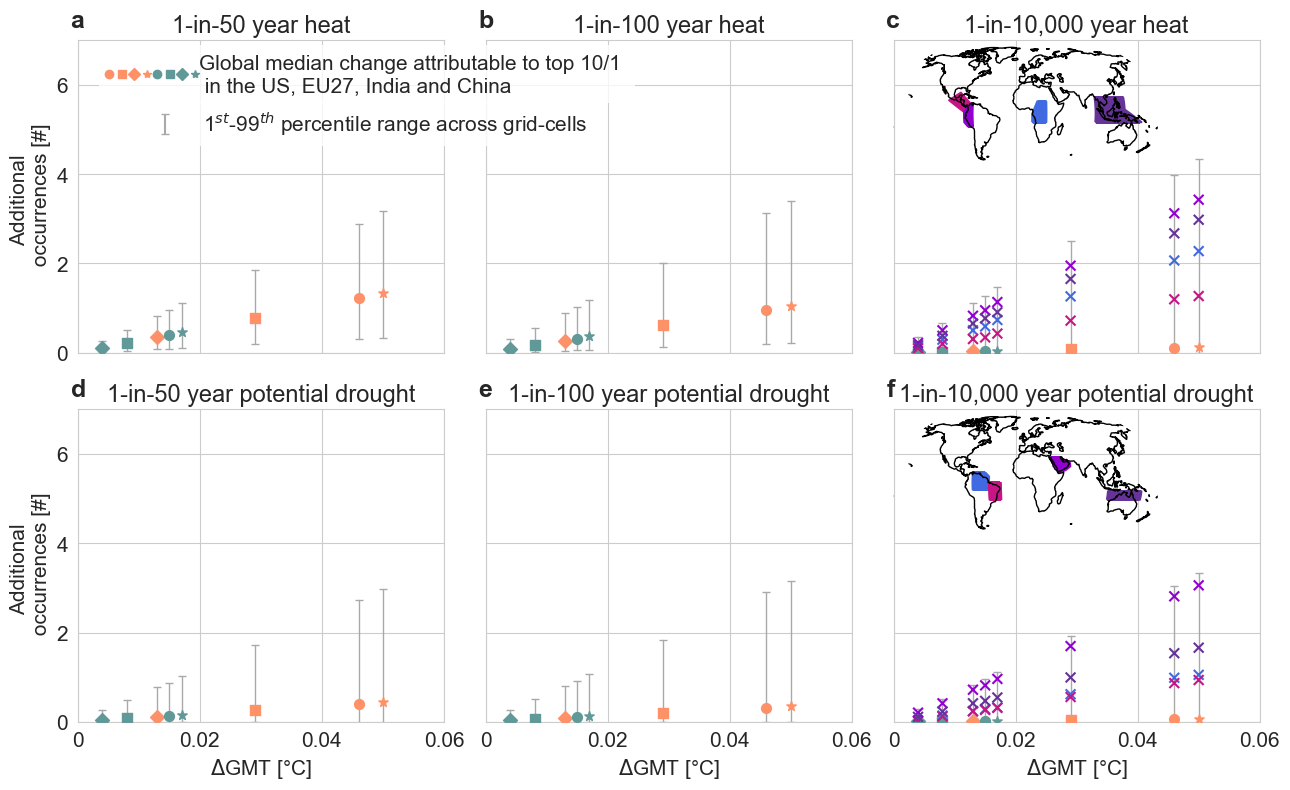

In [34]:
for month in [1,4,7,10]:
    month_name = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'][month]
    titles = ['1-in-50 year heat', 
            '1-in-100 year heat',
            '1-in-10,000 year heat']
    symbols = ['o', 's', 'D', '*', 'P']
    gdf = ar6.to_geodataframe()
    gdf = gdf.set_index("abbrevs")

    # impact_region_colors = cm.PuRd(np.linspace(0.2,1,4))
    impact_region_colors = ['royalblue', 'mediumvioletred', 'darkviolet', 'rebeccapurple']
    impact_region_symbols = ['x','x','x','x']
    emitter_regions = ['US', 'EU27', 'IN', 'CN']
    n_regions = len(emitter_regions)

    with sns.axes_style('whitegrid'): 
        fig  = plt.figure(figsize = (13,8))
        gs   = GridSpec(12, 12, figure=fig)
        
        axes = []
        
        all_sel_tas = {7: [10, 21, 38, 7],  
                       10: [22, 7, 9, 38],  
                        1: [11, 7, 27, 38],  
                        4: [9,24,38,11]}
        sel_impact_regions = all_sel_tas[month]
        region_names = [ar6[region].abbrev for region in sel_impact_regions]

        for i_q in range(3): 
            ax = fig.add_subplot(gs[:6, i_q*4:(i_q+1)*4])
            for i_group in range(2):
                group = ['p90p100', 'p99p100'][i_group]
                for i_region in range(n_regions):    
                    region = emitter_regions[i_region]
                    # distribution bars 
                    ax.plot([magicc_df[(magicc_df.region == region) & (magicc_df.group == group)].loc[:, 'equal-scaling_mean'].values, 
                            magicc_df[(magicc_df.region == region) & (magicc_df.group == group)].loc[:, 'equal-scaling_mean'].values],
                            np.quantile(tas_frequency_df['attributed_tas'].sel(group = group, 
                                                                                region = region, 
                                                                                month = month).isel(extreme_quantile = i_q).mean(dim = 'model').values, q = [0.01, 0.99]),
                            marker = '_', 
                            color= group_colors[0],
                            lw = 1
                            )
                    # 
                    ax.scatter(magicc_df[(magicc_df.region == region) & (magicc_df.group == group)].loc[:, 'equal-scaling_mean'].values,
                            np.median(tas_frequency_df['attributed_tas'].sel(group = group, 
                                                                            region = region, 
                                                                            month = month).isel(extreme_quantile = i_q).mean(dim = 'model').values),
                                s = 50,
                                marker = symbols[i_region],
                                color= group_colors[i_group + 1],
                                zorder = 10
                                )
                    if i_q == 2: 
                        ax.scatter([magicc_df[(magicc_df.region == region) & (magicc_df.group == group)].loc[:, 'equal-scaling_mean'].values]*len(sel_impact_regions), 
                                df_agg_tas['attributed_tas'].sel(group = group, 
                                            region = region, 
                                            month = month, 
                                            mask = sel_impact_regions).isel( extreme_quantile = i_q).mean(dim = 'model').values,
                                s = 50, 
                                marker = 'x',
                                c = impact_region_colors,
                                zorder = 10
                                )

            ax.set_ylim(0,7)
            ax.set_title(titles[i_q], fontsize = fontsize_large)
            if i_q == 0:
                ax.set_yticks([0,2,4,6],
                            [0,2,4,6],
                            fontsize = fontsize_medium)
                ax.set_ylabel('Additional \n occurrences [#]',
                            fontsize = fontsize_medium)
                
            else: 
                ax.set_yticks([0,2,4,6],
                            [])
            ax.set_xticks([0, 0.02, 0.04, 0.06],
                        [])
            # ax.set_xlabel('$\Delta$GMT [°C]', fontsize = fontsize_medium)
            axes.append(ax)
        
        ### add map
        ax = fig.add_subplot(gs[:3, 8:11], projection=ccrs.Robinson(), frameon=False)
        ax.spines['geo'].set_visible(False)
        ax.set_extent([-177, 180, -60, 90], crs=ccrs.PlateCarree())
        ax.coastlines(edgecolor = 'lightgrey')
        for i_impact_region, abbrev in enumerate(region_names): 
            gdf.loc[[abbrev]].plot(ax=ax, transform=ccrs.PlateCarree(), 
                                    facecolor= impact_region_colors[i_impact_region], 
                                    edgecolor = impact_region_colors[i_impact_region], 
                                    lw = 1.5)
            
        titles = ['1-in-50 year potential drought', 
                '1-in-100 year potential drought', 
                '1-in-10,000 year potential drought']
        
        all_sel_spei = {7: [11,25,23,32], 
                10: [10,11,36,39], 
                1: [10,23,21,8], 
                4: [37,20,21,23]}
        sel_impact_regions = all_sel_spei[month]

        region_names = [ar6[region].abbrev for region in sel_impact_regions]
        
        for i_q in range(3): 
            ax = fig.add_subplot(gs[6:, i_q*4:(i_q+1)*4])
            for i_group in range(2):
                group = ['p90p100', 'p99p100'][i_group]
                for i_region in range(n_regions):    
                    region = emitter_regions[i_region]
                    # distribution bars 
                    ax.plot([magicc_df[(magicc_df.region == region) & (magicc_df.group == group)].loc[:, 'equal-scaling_mean'].values, 
                            magicc_df[(magicc_df.region == region) & (magicc_df.group == group)].loc[:, 'equal-scaling_mean'].values],
                            np.quantile(spei_frequency_df['attributed_spei'].sel(group = group, 
                                                                                region = region, 
                                                                                month = month).isel(extreme_quantile = i_q).mean(dim = 'model').values, q = [0.01, 0.99]),
                            marker = '_', 
                            color= group_colors[0],
                            lw = 1
                            )
                    # 
                    ax.scatter(magicc_df[(magicc_df.region == region) & (magicc_df.group == group)].loc[:, 'equal-scaling_mean'].values,
                            np.median(spei_frequency_df['attributed_spei'].sel(group = group, 
                                                                            region = region, 
                                                                            month = month).isel(extreme_quantile = i_q).mean(dim = 'model').values),
                                s = 50,
                                marker = symbols[i_region],
                                color= group_colors[i_group + 1],
                                zorder = 10
                                )
                    if i_q == 2: 
                        ax.scatter([magicc_df[(magicc_df.region == region) & (magicc_df.group == group)].loc[:, 'equal-scaling_mean'].values]*len(sel_impact_regions), 
                                df_agg_spei['attributed_spei'].sel(group = group, 
                                            region = region, 
                                            month = month, 
                                            mask = sel_impact_regions).isel( extreme_quantile = i_q).mean(dim = 'model').values,
                                s = 50, 
                                marker = 'x',
                                c = impact_region_colors,
                                zorder = 10
                                )

            ax.set_ylim(0,7)
            ax.set_title(titles[i_q], 
                        fontsize = fontsize_large)
            if i_q == 0:
                ax.set_yticks([0,2,4,6],
                            [0,2,4,6],
                            fontsize = fontsize_medium)
                ax.set_ylabel('Additional \n occurrences [#]',
                            fontsize = fontsize_medium)
            else: 
                ax.set_yticks([0,2,4,6],
                            [])
            ax.set_xticks([0,0.02, 0.04, 0.06],
                        [0,0.02, 0.04, 0.06],
                        fontsize = fontsize_medium)
            ax.set_xlabel('$\Delta$GMT [°C]', fontsize = fontsize_medium)
            axes.append(ax)
        
        ### add map
        ax = fig.add_subplot(gs[6:9, 8:11], projection=ccrs.Robinson(), frameon=False)
        ax.spines['geo'].set_visible(False)
        ax.set_extent([-177, 180, -60, 90], crs=ccrs.PlateCarree())
        ax.coastlines(edgecolor = 'lightgrey')
        for i_impact_region, abbrev in enumerate(region_names): 
            gdf.loc[[abbrev]].plot(ax=ax, transform=ccrs.PlateCarree(), 
                                    facecolor= impact_region_colors[i_impact_region], 
                                    edgecolor = impact_region_colors[i_impact_region], 
                                    lw = 1.5)
        
        xs = [-0.02]*6
        ys = [1.1]*6
        lettering = ['a', 'b', 'c', 'd', 'e', 'f']
        for i in range(6):
                axes[i].text(xs[i], ys[i], lettering[i], transform=axes[i].transAxes, fontsize=fontsize_large+1, fontweight='bold', va='top')

        from matplotlib.container import ErrorbarContainer
        from matplotlib.lines import Line2D
        from matplotlib.collections import LineCollection
        
        line = Line2D([],[], ls="none", color = 'darkgrey')
        circle =  Line2D([],[], lw=0, color = 'darkgrey', marker = 'o')
        symbols_legend_orange = tuple([Line2D([],[], lw=0, color = group_colors[1], marker = symbol) for symbol in symbols[:-1]])
        symbols_legend_teal = tuple([Line2D([],[], lw=0, color = group_colors[2], marker = symbol) for symbol in symbols[:-1]])
        barline = LineCollection(np.empty((2,2,2)), color = 'darkgrey')
        err = ErrorbarContainer((line, [line], [barline]), has_xerr=False, has_yerr=True)

        legend = fig.legend(handles=[symbols_legend_orange, 
                            symbols_legend_teal], labels=["", "Global median change attributable to top 10/1 \n in the US, EU27, India and China"], 
                            fontsize = fontsize_medium,
                            title_fontsize = fontsize_medium,
                            edgecolor = 'none',
                            facecolor = (1,1,1,0.7),
                            handler_map={tuple: HandlerTuple(ndivide=None)},
                            ncols = 2,
                            handletextpad=0.1,
                            columnspacing = 0.2,
                            bbox_to_anchor = (0.5, 0.95),
                            )     
        fig.legend(handles=[err], labels=["1$^{st}$-99$^{th}$ percentile range across grid-cells"], 
                    fontsize = fontsize_medium,
                    edgecolor = 'none',
                    facecolor = (1,1,1,0.7),
                    bbox_to_anchor = (0.47, 0.88))
        
        fig.tight_layout()
        plt.savefig(GRAPHICS_PAPER_APPENDIX_DIR / 'graphics' / f'change_in_likelihood_{month_name}.pdf', dpi = 600)
        plt.show()
    